In [35]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib import cm
import acoustid
import base64
import random
import csv
import os
import glob

In [36]:
music_noise_path=["C:\\Users\\haim1\\noise\\noise 1_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 2_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 3_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 4_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 5_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 6_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 7_29s_norm.mp3"]

# 시드 고정
random.seed(42)

# 하임 추가 : 에러가 뜨는 주소 정보 저장하기
error_list = []

def get_row_by_mp3_file(csv_file_path, mp3_file):
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)  # 헤더를 읽어옴

        for row in csv_reader:
            if row[0] == mp3_file:
                return row

    return None  # 해당하는 mp3_file이 없을 경우 None 반환

def save_key_trans(mp3_file, dirname, name, key_shift, mp3_w_noise):
    try:
        y, sr = librosa.load(mp3_file, sr=None,duration=29.0)
        
        if (sr!=44100):
            print(f"{name}'s sr is {sr}")
            return 0, 0
        
#         desired_shape = (1278900,)
#         y = np.resize(y, desired_shape)
    
        y_norm = y / np.max(np.abs(y)) # normalization
        if key_shift != 0:
            y_norm = librosa.effects.pitch_shift(y_norm, sr=sr, n_steps=key_shift)
        output_file=f"C:\\Users\\haim1\\UGRP FMA MUSIC\\{dirname}\\{name}\\{name} KEY {key_shift}.mp3"
        sf.write(output_file, y_norm, sr)
        
        if (mp3_w_noise != 0):
    #         random_number = random.randint(0, 6) # 0~6 중 랜덤으로 뽑기
            csv_file_path = f"C:\\Users\\haim1\\random_noise_index\\{dirname}_random_noise_indexes.csv"
    
            # result_row 형식: ['000005', '4', '0', '4', '1', '5', '5', '5', '4', '3', '1', '3']
            result_row = get_row_by_mp3_file(csv_file_path, name)
            random_number = int(result_row[mp3_w_noise])
        
            noise = music_noise_path[random_number] # music_noise_path에는 잘 잘라둔 노이즈파일의 절대경로가 들어가있을 것
            y_noise, sr = librosa.load(noise, sr=None)
            y_norm += y_noise # noise 더하기
            with_noise_file_path = f"C:\\Users\\haim1\\UGRP FMA MUSIC\\{dirname}\\{name}\\{name} KEY {key_shift} with noise {random_number+1}.mp3"

            sf.write(with_noise_file_path, y_norm, sr)
        
            return output_file, with_noise_file_path # noise가 있는 음원 return
        return output_file, 0 # key change만 있는 음원 return
# (원래 코드)
#     except:
#         print(f"{dirname}\\{name} can't play")
#         return
    
    # 하임 추가 : 에러메세지 볼 수 있게 추가했습니다.  
    except Exception as E:
        print(f"{dirname}\\{name} can't play")
        print(f" < Error > {E}")
        error_list.append((dirname, name, E))
        return 0, 0
    
#    desired_shape = (1278900,)
#    y = np.resize(y, desired_shape)
    
#    y_norm = y / np.max(np.abs(y)) # normalization
#    if key_shift != 0:
#        y_norm = librosa.effects.pitch_shift(y_norm, sr=sr, n_steps=key_shift)
#    output_file=f"C:\\Users\\haim1\\UGRP FMA MUSIC\\{dirname}\\{name}\\{name} KEY {key_shift}.mp3"
#    sf.write(output_file, y_norm, sr)

#    random_number = random.randint(0, 6) # 0~6 중 랜덤으로 뽑기
#    noise = music_noise_path[random_number] # music_noise_path에는 잘 잘라둔 노이즈파일의 절대경로가 들어가있을 것
#    y_noise, sr = librosa.load(noise, sr=None)
#    y_norm += y_noise # noise 더하기
#    with_noise_file_path = f"C:\\Users\\haim1\\UGRP FMA MUSIC\\{dirname}\\{name}\\{name} KEY {key_shift} with noise {random_number+1}.mp3"

#    sf.write(with_noise_file_path, y_norm, sr)


In [37]:
def extract_fingerprint(file_path):
    try:
        duration, fp_encoded = acoustid.fingerprint_file(file_path)
        fingerprint_str = base64.b64encode(fp_encoded).decode('utf-8')
        fingerprint_int = [ord(char) for char in fingerprint_str]
        return fingerprint_int
    except Exception as e:
        print(f"Error extracting fingerprint for {file_path}: {e}")
        return None
    
def extract_chromagram_stft(file_path, file_name, type="npy"):
    try:
        y, sr = librosa.load(file_path, sr=None)
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
        
        if (type=="npy"):
            save_dir = f"E:\\UGRP\\npy\\cg\\{file_name}"
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            save_path = os.path.splitext(os.path.basename(file_path))[0].split(' ', 1)[1]
            save_path = os.path.join(save_dir, save_path)
            save_path = os.path.splitext(save_path)[0] + "_cg.npy"
            np.save(save_path, chromagram)
            return
        
        if (type=="jpg"):
            save_dir = f"E:\\UGRP\\image\\cg\\{file_name}"
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            save_path = os.path.splitext(os.path.basename(file_path))[0].split(' ', 1)[1]
            save_path = os.path.join(save_dir, save_path)
            save_path = os.path.splitext(save_path)[0] + "_cg.jpg"
            
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(chromagram, sr=sr)

            plt.axis('off')
            plt.tight_layout()
            # mfcc.jpg 저장
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            return
  
    except Exception as e:
        print(f"Error extracting chromagram for {file_path}: {e}")
        return None
    
def extract_spectrogram(file_path, file_name, type="npy"):
    # file_path : "C:\어쩌구\000002 KEY 0 with noise 5.mp3" or "C\어쩌구\000002 KEY 0.mp3"
    # file_name : 000002
    try:
        y, sr = librosa.load(file_path, sr=None)
        y = librosa.stft(y)
        spectrogram = librosa.amplitude_to_db(np.abs(y), ref=np.max)
        
        if (type=="npy"):
            save_dir = f"E:\\UGRP\\npy\\sg\\{file_name}"
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            save_path = os.path.splitext(os.path.basename(file_path))[0].split(' ', 1)[1]
            save_path = os.path.join(save_dir, save_path)
            save_path = os.path.splitext(save_path)[0] + "_sg.npy"
            np.save(save_path, spectrogram)
            return
        
        if (type=="jpg"):
            plt.figure(figsize=(10, 4))
#             librosa.display.specshow(spectrogram, sr=sr)
            librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', sr=sr)
            plt.axis('off')
            plt.tight_layout()
            # sppectrogram .jpg 저장
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()
        
    except Exception as e:
        print(f"Error extracting spectrogram for {file_path}: {e}")
        return None
    
def extract_mfcc(file_path, file_name, type="npy"):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        
        if (type=="npy"):
            save_dir = f"E:\\UGRP\\npy\\mfcc\\{file_name}"
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            save_path = os.path.splitext(os.path.basename(file_path))[0].split(' ', 1)[1]
            save_path = os.path.join(save_dir, save_path)
            save_path = os.path.splitext(save_path)[0] + "_mfcc.npy"
            np.save(save_path, mfcc)
            return
            
        if (type=="jpg"):
            save_dir = f"E:\\UGRP\\image\\mfcc\\{file_name}"
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            save_path = os.path.splitext(os.path.basename(file_path))[0].split(' ', 1)[1]
            save_path = os.path.join(save_dir, save_path)
            save_path = os.path.splitext(save_path)[0] + "_mfcc.jpg"
            
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, sr=sr)

            plt.axis('off')
            plt.tight_layout()
            # mfcc.jpg 저장
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            return
        
    except Exception as e:
        print(f"Error extracting MFCC for {file_path}: {e}")
        return None

def process_audio_files(base_dir, save_base_dir, feature_extractor, file_extension, output_format):
    for root, subdirs, files in os.walk(base_dir):
        for subdir in subdirs:
            directory_path = os.path.join(root, subdir)

            mp3_files = [file for file in os.listdir(directory_path) if file.endswith(file_extension)]
            print(f"{subdir}")
            if mp3_files:
                save_directory_path = os.path.join(save_base_dir, os.path.relpath(directory_path, base_dir))
                os.makedirs(save_directory_path, exist_ok=True)

                for mp3_file in mp3_files:
                    mp3_path = os.path.join(directory_path, mp3_file)  

                    feature = feature_extractor(mp3_path)

                    if feature is not None:
                        save_filename = os.path.splitext(mp3_file)[0] + output_format
                        save_path = os.path.join(save_directory_path, save_filename)

                        if output_format in ['_mfcc.jpg', '_sg.jpg', '_cg.jpg']:
                            try:
                                plt.figure(figsize=(10, 4))
                                if feature_extractor == extract_chromagram_stft:
                                    librosa.display.specshow(feature, y_axis='chroma', x_axis='time')
                                elif feature_extractor == extract_spectrogram:
                                    librosa.display.specshow(feature, y_axis='log', x_axis='time')
                                else:
                                    librosa.display.specshow(feature, x_axis='time')
                                plt.axis('off')
                                plt.tight_layout()
                                plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0)
                                plt.close()
                            except Exception as e:
                                print(f"Error saving image for {mp3_path}: {e}")
                        else:
                            try:
                                np.save(save_path, feature)
                            except Exception as e:
                                print(f"Error saving feature vector for {mp3_path}: {e}")

In [42]:
# mfcc 새로 추출하려면 여기까지 돌려주세요!
# 시작 디렉터리 설정 (fma_medium 디렉터리 경로)

start_file = "015148" #시작 파일
final_dir = "025" #끝 디렉토리 (여기까지)

key_change = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]

start_dir = start_file[:3]

start_directory = "fma_medium"

''' random_noise_index 저장 코드
def write_to_csv(file_path, data, header=False):
    with open(file_path, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # 헤더를 쓰는 옵션 추가
        if header:
            csv_writer.writerow(data)
        else:
            csv_writer.writerow(data)'''

# 시작 디렉터리 안의 모든 하위 디렉터리 탐색
for root, dirs, files in os.walk(start_directory):
    for dir_name in dirs:
        # 각 하위 디렉터리에 접근
        dir_path = os.path.join(root, dir_name)
        print(f'dir_path: {dir_path}')

        # 디렉터리 이름 추출 (000 또는 001)
        dir_name = os.path.basename(dir_path)
        print(f'dir_name: {dir_name}')
        int_dir_name = int(dir_name)
        
        if (int(start_dir) <= int_dir_name <=int(final_dir)) :
            print(f'{dir_name} : {int(start_dir)} <= int_dir_name <= {int(final_dir)}')

            # 해당 하위 디렉터리 안의 MP3 파일 찾기
            mp3_files = glob.glob(os.path.join(dir_path, "*.mp3"))
    #         print(f'mp3_files: {mp3_files}')
    
            # MP3 파일들을 반복문으로 처리
            for mp3_file in mp3_files:
                
                absolute_path = os.path.abspath(mp3_file)
    #             print(f'absolute_path: {absolute_path}')
    
                file_name = os.path.splitext(os.path.basename(mp3_file))[0]
                print(f'file_name: {file_name}')
                
                if (int(file_name)<int(start_file)):
                    print(f'{file_name} < {start_file}')
                    continue
    
                output_directory = os.path.join("C:\\Users\\haim1\\UGRP FMA MUSIC", dir_name)
    #             print(f'좀 위 폴더: {output_directory}')
                if not os.path.exists(output_directory):
                    os.mkdir(output_directory)
    
                # 저장할 디렉터리 경로 설정
                output_directory = os.path.join("C:\\Users\\haim1\\UGRP FMA MUSIC", dir_name, file_name)
                print(f'output_directory: {output_directory}')
    
                # 결과 디렉터리가 없으면 생성
                if not os.path.exists(output_directory):
                    os.mkdir(output_directory)
                
                ''' random_noise_index 저장 코드
                # 새로운 랜덤 숫자를 생성하고 리스트에 저장
                new_random_numbers = [file_name] + [random.randint(0, 6) for _ in range(11)]  # 11개의 숫자 생성
                    
                # 기존 CSV 파일이 없으면 헤더를 포함하여 새로운 파일 생성
                csv_file_path = f'C:\\Users\\haim1\\random_noise_index\\{dir_name}_random_noise_indexes.csv'
                if not os.path.isfile(csv_file_path):
                    write_to_csv(csv_file_path,['mp3 file'] + [f'Key shift {i}' for i in range(-5, 6)], header=True)
                        
                # 기존 CSV 파일에 데이터 추가
                write_to_csv(csv_file_path, new_random_numbers)'''
                
                # key change 중 noise 들어갈 4개 선택
                mp3_w_noise = [0] * len(key_change)
                nums = [1, 2, 3, 4]
                ones_indices = random.sample(range(len(key_change)), 4)
                ones_indices.sort()
                for i in range(4):
                    mp3_w_noise[ones_indices[i]] = nums[i]
    
                for i in range(len(key_change)):
                    trans_path, w_noise_path = save_key_trans(absolute_path, dir_name, file_name, key_change[i], mp3_w_noise[i])
                    
                    if (trans_path!=0):
                        # 스펙트로그램
    #                     print("Processing spectrograms and images")
    #                     extract_spectrogram(trans_path, file_name)
    
                        # 크로마그램
                        print("Processing chromagram w/o noise")
                        extract_chromagram_stft(trans_path, file_name)
                        
                        # MFCC
#                         print("Processing MFCC npy")
#                         extract_mfcc(trans_path, file_name)
                    
                    if (w_noise_path!=0):
                        # 스펙트로그램
    #                     print("Processing spectrograms and images")
    #                     extract_spectrogram(w_noise_path, file_name)
                        
                        # 크로마그램
                        print("Processing chromagram w/ noise")
                        extract_chromagram_stft(w_noise_path, file_name)
                        
                        # MFCC
#                         print("Processing MFCC npy")
#                         extract_mfcc(w_noise_path, file_name)
                        
                        try:
                            os.remove(trans_path)
                            os.remove(w_noise_path)
                        except Exception as e:
                            print(f"파일 지우다가 에러 발생: {e}")
    #                     process_audio_files(base_dir, save_base_dir, extract_spectrogram, '.mp3', '_sg.npy')

dir_path: fma_medium\000
dir_name: 000
dir_path: fma_medium\001
dir_name: 001
dir_path: fma_medium\002
dir_name: 002
dir_path: fma_medium\003
dir_name: 003
dir_path: fma_medium\004
dir_name: 004
dir_path: fma_medium\005
dir_name: 005
dir_path: fma_medium\006
dir_name: 006
dir_path: fma_medium\007
dir_name: 007
dir_path: fma_medium\008
dir_name: 008
dir_path: fma_medium\009
dir_name: 009
dir_path: fma_medium\010
dir_name: 010
dir_path: fma_medium\011
dir_name: 011
dir_path: fma_medium\012
dir_name: 012
dir_path: fma_medium\013
dir_name: 013
dir_path: fma_medium\014
dir_name: 014
dir_path: fma_medium\015
dir_name: 015
015 : 15 <= int_dir_name <= 25
file_name: 015002
015002 < 015148
file_name: 015010
015010 < 015148
file_name: 015011
015011 < 015148
file_name: 015022
015022 < 015148
file_name: 015023
015023 < 015148
file_name: 015094
015094 < 015148
file_name: 015095
015095 < 015148
file_name: 015105
015105 < 015148
file_name: 015106
015106 < 015148
file_name: 015108
015108 < 015148
file_

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 015207
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015207
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Pr

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015265
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015265
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015376
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015376
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 015436
output_director

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 015487
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015487
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015488
output_directory: C:\Users\haim1\UGRP FMA MUSIC

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 015607
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015607
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015608
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015608
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015769
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015769
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 015770
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015770
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015866
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015866
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015867
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015867
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 015966
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015966
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015967
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015967
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 015997
output_directory: C:\Users\haim1\UGRP FMA MUSIC\015\015997
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
dir_path: fma_medium\016
dir_name: 016
016 : 15 <= int_dir_name <= 25
file_name: 016023
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016023
016023's sr is 48000
016023's sr is 48000
016023's sr is 48000
016023's sr is 48000
016023's sr is 48000
016

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016055
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016055
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016056
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016056
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016161
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016161
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016162
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016162
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016289
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016289
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016296
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016296
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 016366
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016366
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pro

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016382
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016382
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Pr

016399's sr is 22050
016399's sr is 22050
file_name: 016400
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016400
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
016400's sr is 22050
file_name: 016401
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016401
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
016401's sr is 22050
file_name: 016402
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016402
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr is 22050
016402's sr i

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 016437
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016437
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
fil

C:\Users\haim1\Downloads\ananconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016523
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016523
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016524
output_director

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016562
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016562
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016563
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016563
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016589
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016589
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 016590
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016590
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016701
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016701
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 016702
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016702
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 016765
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016765
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 016769
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016769
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016828
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016828
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016829
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016829
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 016982
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016982
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 016983
output_directory: C:\Users\haim1\UGRP FMA MUSIC\016\016983
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017259
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017259
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017321
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017321
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017422
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017422
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017426
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017426
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 017452
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017452
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017453
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017453
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017489
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017489
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017490
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017490
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017580
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017580
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pro

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017607
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017607
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 017608
output_directory

017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
017637's sr is 22050
file_name: 017643
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017643
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017644
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017644
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 017712
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017712
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 017729
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017729
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017827
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017827
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017828
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017828
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017880
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017880
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017881
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017881
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017910
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017910
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 017911
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017911
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 017995
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017995
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 017996
output_directory: C:\Users\haim1\UGRP FMA MUSIC\017\017996
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 018009
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018009
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 018010
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018010
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 018023
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018023
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 018024
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018024
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
file_name: 018039
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018039
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 018040
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018040
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 018159
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018159
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 018325
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018325
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 018446
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018446
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 018577
output_director

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 018613
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018613
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 018614
output_directory: C:\Users\haim1\UGRP FMA MUSIC\

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 018692
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018692
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 018694
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018694
Processing chromagram

018804's sr is 48000
018804's sr is 48000
018804's sr is 48000
018804's sr is 48000
018804's sr is 48000
018804's sr is 48000
file_name: 018805
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018805
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
018805's sr is 48000
file_name: 018806
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018806
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
018806's sr is 48000
file_name: 018822
output_directory: C:\Users\haim1\UGRP FMA MUSIC\018\018822
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing c

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 019074
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019074
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 019125
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019125
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 019179
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019179
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019180
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019180
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019236
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019236
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 019262
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019262
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019331
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019331
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 019332
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019332
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 019392
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019392
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 019393
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019393
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagra

Processing chromagram w/o noise
file_name: 019423
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019423
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 019425
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019425
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 019470
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019470
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 019550
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019550
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Pro

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019603
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019603
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Pro

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019630
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019630
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
fi

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019668
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019668
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019669
output_directory

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 019720
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019720
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019721
output_directory: C:\Users\haim1\UGRP FMA MUSIC

Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019775
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019775
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 019790
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019790
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
file_name: 019986
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019986
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 019989
output_directory: C:\Users\haim1\UGRP FMA MUSIC\019\019989
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020058
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020058
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 020059
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020059
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
file_name: 020097
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020097
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020098
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020098
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020137
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020137
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020156
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020156
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020198
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020198
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
fi

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020231
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020231
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020234
output_directory:

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020365
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020365
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 020366
output_directory: C:\Users\haim1\UGRP FMA MUSIC\

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020444
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020444
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020445
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020445
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020465
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020465
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020466
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020466
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 020664
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020664
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020665
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020665
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 020686
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020686
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 020692
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020692
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram 

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020735
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020735
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020736
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020736
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 020750
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020750
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 020751
output_directory: C:\Users\haim1\UGRP FMA MUSIC\020\020751
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021013
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021013
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021058
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021058
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021134
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021134
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021135
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021135
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 021167
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021167
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021168
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021168
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021227
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021227
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021228
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021228
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 021353
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021353
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
fil

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021419
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021419
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021420
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021420
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021555
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021555
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021556
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021556
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021679
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021679
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021680
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021680
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
021798's sr is 48000
file_name: 021799
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021799
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
021799's sr is 48000
file_name: 021800
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021800
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
021800's sr is 48000
file_name: 021839
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021839
Processing ch

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021861
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021861
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021885
output_directory

Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021898
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021898
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 021899
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021899
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
file_name: 021963
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021963
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 021964
output_directory: C:\Users\haim1\UGRP FMA MUSIC\021\021964
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022024
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022024
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022029
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022029
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
file_name: 022091
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022091
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 022093
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022093
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 022130
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022130
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pro

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022150
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022150
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 022332
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022332
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
fil

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022355
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022355
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 022356
output_directory

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 022377
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022377
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022378
output_directory: C:\Users\haim1\UGRP FMA MUSIC\

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 022453
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022453
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022454
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022454
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 022479
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022479
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022480
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022480
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022599
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022599
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 022601
output_directory: C:\Users\haim1\UGRP FMA MUSIC\022\022601
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023037
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023037
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023038
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023038
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023081
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023081
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023082
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023082
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagra

Processing chromagram w/o noise
file_name: 023155
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023155
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023156
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023156
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023353
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023353
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pro

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 023449
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023449
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 023482
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023482
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
fil

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023507
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023507
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023508
output_directory:

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023528
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023528
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 023529
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023529
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023678
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023678
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023764
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023764
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 023824
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023824
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023826
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023826
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 023881
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023881
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 023882
output_directory: C:\Users\haim1\UGRP FMA MUSIC\023\023882
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024060
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024060
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024062
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024062
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram 

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024176
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024176
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024177
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024177
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024368
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024368
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024369
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024369
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024429
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024429
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024430
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024430
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagr

Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024524
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024524
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024544
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024544
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

file_name: 024641
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024641
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024654
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024654
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024745
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024745
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 024800
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024800
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pr

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024817
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024817
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Pro

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024902
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024902
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024903
output_directory

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024923
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024923
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024925
output_directory: C:\Users\haim1\UGRP FMA MUSIC

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024966
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024966
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 024971
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024971
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 024992
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024992
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 024993
output_directory: C:\Users\haim1\UGRP FMA MUSIC\024\024993
Processing chromagram w/o noise
Processing chromagra

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 025013
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025013
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 025014
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025014
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 025104
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025104
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 025111
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025111
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 025152
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025152
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
file_name: 025153
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025153
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 025234
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025234
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
file_name: 025235
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025235
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagr

025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
025379's sr is 48000
file_name: 025380
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025380
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
025380's sr is 48000
file_name: 025381
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025381
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
025381's sr is 48000
file_name: 025382
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025382
025382's sr is 48000
025382's sr is 48000
025382's sr i

Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
file_name: 025735
output_directory: C:\Users\haim1\UGRP FMA MUSIC\025\025735
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/ noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Processing chromagram w/o noise
Pr

In [ ]:
from pydub import AudioSegment

In [ ]:
mp3_file_path = ["C:\\Users\\haim1\\noise\\noise 1_29s_norm.mp3","C:\\Users\\haim1\\noise\\noise 2_29s_norm.mp3","C:\\Users\\haim1\\noise\\noise 3_29s_norm.mp3",
                "C:\\Users\\haim1\\noise\\noise 4_29s_norm.mp3","C:\\Users\\haim1\\noise\\noise 5_29s_norm.mp3","C:\\Users\\haim1\\noise\\noise 6_29s_norm.mp3",
                "C:\\Users\\haim1\\noise\\noise 7_29s_norm.mp3"]
for mp3 in mp3_file_path:
    audio=AudioSegment.from_mp3(mp3)
    audio_data = np.array(audio.get_array_of_samples())
    print(audio_data.shape)

In [ ]:
#044부터 다시시작
#048부터 다시시작

# 시작 디렉터리 설정 (fma_medium 디렉터리 경로)
start_directory = "fma_medium"
start_processing = False

for root, dirs, files in os.walk(start_directory):
    for dir_name in dirs:
        if dir_name == '048':
            start_processing = True  # Set the flag to start processing from 004 directory
        if not start_processing:
            continue

        # 각 하위 디렉터리에 접근
        dir_path = os.path.join(root, dir_name)
        print(f'dir_path: {dir_path}')

        # 해당 하위 디렉터리 안의 MP3 파일 찾기
        mp3_files = glob.glob(os.path.join(dir_path, "*.mp3"))
        print(f'mp3_files: {mp3_files}')

        # MP3 파일들을 반복문으로 처리
        for mp3_file in mp3_files:

            absolute_path = os.path.abspath(mp3_file)
            print(f'absolute_path: {absolute_path}')

            file_name = os.path.splitext(os.path.basename(mp3_file))[0]
            print(f'file_name: {file_name}')

            # 디렉터리 이름 추출 (000 또는 001)
            dir_name = os.path.basename(dir_path)
            print(f'dir_name: {dir_name}')

            output_directory = os.path.join("C:\\Users\\haim1\\UGRP FMA MUSIC", dir_name)
            print(f'좀 위 폴더: {output_directory}')
            if not os.path.exists(output_directory):
                os.mkdir(output_directory)

            # 저장할 디렉터리 경로 설정
            output_directory = os.path.join("C:\\Users\\haim1\\UGRP FMA MUSIC", dir_name, file_name)
            print(f'output_directory: {output_directory}')

            # 결과 디렉터리가 없으면 생성
            if not os.path.exists(output_directory):
                os.mkdir(output_directory)

            for key in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
                save_key_trans(absolute_path, dir_name, file_name, key)

In [ ]:
# 하임 추가 : 에러가 발생하는 파일 정보 간단하게 출력하는 코드 (맨 위의 함수 재정의 이후 사용 가능)
for i in error_list:
    print(i)

In [ ]:
#에러 문제 확인
music_noise_path=["C:\\Users\\haim1\\noise\\noise 1_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 2_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 3_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 4_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 5_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 6_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 7_29s_norm.mp3"]


def save_key_trans_2(mp3_file, name, key_shift=0):
    try:
        y, sr = librosa.load(mp3_file, sr=None,duration=29.0)
        desired_shape = (1278900,)
        y = np.resize(y, desired_shape)
    
        y_norm = y / np.max(np.abs(y)) # normalization
        if key_shift != 0:
            y_norm = librosa.effects.pitch_shift(y_norm, sr=sr, n_steps=key_shift)
        output_file=f"C:\\Users\\haim1\\UGRP MUSIC ERROR SAVE\\{name}\\{name} KEY {key_shift}.mp3"
        sf.write(output_file, y_norm, sr)

        random_number = random.randint(0, 6) # 0~6 중 랜덤으로 뽑기
        noise = music_noise_path[random_number] # music_noise_path에는 잘 잘라둔 노이즈파일의 절대경로가 들어가있을 것
        y_noise, sr = librosa.load(noise, sr=None)
        y_norm += y_noise # noise 더하기
        with_noise_file_path = f"C:\\Users\\haim1\\UGRP MUSIC ERROR SAVE\\{name}\\{name} KEY {key_shift} with noise {random_number+1}.mp3"

        sf.write(with_noise_file_path, y_norm, sr)
        
    except Exception as e:
        print(f"Error in save_key_trans_2 for file {mp3_file}: {e}")

In [ ]:
start_directory = "UGRP MUSIC ERROR"

for mp3_file in glob.glob(os.path.join(start_directory, "*.mp3")):
    absolute_path = os.path.abspath(mp3_file)
    print(f'absolute_path: {absolute_path}')

    file_name = os.path.splitext(os.path.basename(mp3_file))[0]
    print(f'file_name: {file_name}')

    output_directory = os.path.join("C:\\Users\\haim1\\UGRP FMA MUSIC", file_name)
    print(f'output_directory: {output_directory}')

    # 결과 디렉터리가 없으면 생성
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    for key in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
        save_key_trans_2(absolute_path, file_name, key)

In [12]:
import csv

def get_row_by_mp3_file(csv_file_path, mp3_file):
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)  # 헤더를 읽어옴

        for row in csv_reader:
            if row[0] == mp3_file:
                return row

    return None  # 해당하는 mp3_file이 없을 경우 None 반환

# 예시
dir_name = '000'
mp3_file_to_get = '000005'

csv_file_path = f'C:\\Users\\haim1\\random_noise_index\\{dir_name}_random_noise_indexes.csv'
result_row = get_row_by_mp3_file(csv_file_path, mp3_file_to_get)

if result_row:
    print(f"Found {mp3_file_to_get}:\n{result_row}")
else:
    print(f"{mp3_file_to_get} not found in the CSV file.")


Found 000005:
['000005', '4', '0', '4', '1', '5', '5', '5', '4', '3', '1', '3']


In [14]:
int(result_row[1])

4

In [1]:
# 현주 (11/19)
# 변수명은 바꾸기 귀찮아서 sg이지만 mfcc shape 안맞는거 확인해본 코드임
import os
import numpy as np

def find_npy_files(directory):
    npy_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".npy"):
                npy_files.append(os.path.join(root, file))
    return npy_files

# 특정 디렉토리에서 .npy 파일 찾기
directory_path = 'C:\\Users\\haim1\\MFCC'
npy_files = find_npy_files(directory_path)

sg_shape_error = []

# 찾은 .npy 파일 출력
for npy_file in npy_files:
#     print(npy_file)
                
    sg_path = npy_file                    
    sg_npy = np.load(sg_path)
                    
    if (sg_npy.shape != (13,1249)):
        print(sg_path)
        print("Shape:",sg_npy.shape)
        print()
        sg_shape_error.append(sg_path)
        continue
    
#     print(sg_path)
    print(sg_npy.shape)
#     print()
print("="*30)
print(sg_shape_error)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
C:\Users\haim1\MFCC\006517\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006517\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006517\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006517\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006517\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\006519\KEY 3_mfcc.npy
Shape:

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\009887\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\009887\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\012602\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\012602\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\012602\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\012602\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\012602\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\012602\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\012602\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\User

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\015094\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\015094\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\016351\KEY -1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY -2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY -3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY -4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY -5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY 0_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY 1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY 2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY 3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY 4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016351\KEY 5_mfcc.npy
Shape: (13, 2498)

(13, 

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\016398\KEY -1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY -2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY -3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY -4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY -5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY 0_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY 1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY 2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY 3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY 4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016398\KEY 5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016399\

C:\Users\haim1\MFCC\016431\KEY 5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY -1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY -2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY -3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY -4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY -5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY 0_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY 1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY 2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY 3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY 4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\016432\KEY 5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

C:\Users\haim1\MFCC\017631\KEY 3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017631\KEY 4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017631\KEY 5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY -1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY -2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY -3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY -4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY -5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY 0_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY 1_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY 2_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY 3_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY 4_mfcc.npy
Shape: (13, 2498)

(13, 1249)
C:\Users\haim1\MFCC\017632\KEY 5_mfcc.npy
Shape: (13, 2498)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\018802\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\018802\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\018802\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\018802\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\018802\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\018802\KEY

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

C:\Users\haim1\MFCC\019729\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\019729\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\019729\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\021890\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\021890\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
(13, 1249)
(13, 

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

C:\Users\haim1\MFCC\025365\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025365\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025367\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025367\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025367\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025367\KEY -4_mfcc.npy
Shape: (13, 11

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025378\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025379\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025379\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025379\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025379\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025379\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025379\KEY 0_mfcc.npy
Shap

C:\Users\haim1\MFCC\025391\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\025391\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\028110\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028110\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\028111\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

C:\Users\haim1\MFCC\030898\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030898\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\030900\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030900\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\030900\KEY -3_

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

C:\Users\haim1\MFCC\031243\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031245\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031246\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\031246\KEY -2_mfcc.npy
Shape: (13, 114

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
C:\Users\haim1\MFCC\036272\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY -2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY -3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY -4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY -5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY 0_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY 1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY 2_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY 3_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY 4_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036272\KEY 5_mfcc.npy
Shape: (13, 1148)

(13, 1249)
C:\Users\haim1\MFCC\036273\KEY -1_mfcc.npy
Shape: (13, 1148)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)
(13, 1249)

In [43]:
# 현주 (11/19)
# shape 안맞는 mfcc 파일 확인

mfcc_shape = set()
shape_error_files = set()
for i in sg_shape_error:
    print(i)
    directory = os.path.dirname(i)
    desired = directory.split("\\")[-1]
#     print(desired)
    shape_error_files.add(desired)
    mfcc_npy = np.load(i)
#     print(mfcc_npy.shape)
#     print()
    mfcc_shape.add(mfcc_npy.shape)

print(mfcc_shape)
# print(len(sg_shape_error))

shape_error_files = list(shape_error_files)
shape_error_files.sort()
for i in shape_error_files:
    print(i)

C:\Users\haim1\MFCC\001311\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY -3_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY -5_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY 0_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY 1_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY 2_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY 3_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY 4_mfcc.npy
C:\Users\haim1\MFCC\001311\KEY 5_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY -3_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY -5_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY 0_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY 1_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY 2_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY 3_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY 4_mfcc.npy
C:\Users\haim1\MFCC\001642\KEY 5_mfcc.npy
C:\Users\haim1\MFCC\001644\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\001

C:\Users\haim1\MFCC\018802\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY -5_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY 0_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY 1_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY 2_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY 3_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY 4_mfcc.npy
C:\Users\haim1\MFCC\018802\KEY 5_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY -3_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY -5_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY 0_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY 1_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY 2_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY 3_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY 4_mfcc.npy
C:\Users\haim1\MFCC\018803\KEY 5_mfcc.npy
C:\Users\haim1\MFCC\018804\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\018804\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\018804\KEY -3_mfcc.npy
C:\Users\haim1\MFCC\018804\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\018

C:\Users\haim1\MFCC\029355\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY -3_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY -5_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY 0_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY 1_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY 2_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY 3_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY 4_mfcc.npy
C:\Users\haim1\MFCC\029355\KEY 5_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY -3_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY -4_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY -5_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY 0_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY 1_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY 2_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY 3_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY 4_mfcc.npy
C:\Users\haim1\MFCC\030002\KEY 5_mfcc.npy
C:\Users\haim1\MFCC\030897\KEY -1_mfcc.npy
C:\Users\haim1\MFCC\030897\KEY -2_mfcc.npy
C:\Users\haim1\MFCC\030

In [44]:
# 현주 (11/19)
# shape 안맞는 mfcc들 삭제
import shutil

base_path = "C:\\Users\\haim1\\MFCC"

for dir_name in shape_error_files:
    directory_path = os.path.join(base_path, dir_name)
    
    try:
        shutil.rmtree(directory_path)
        print(f"디렉토리 '{directory_path}'가 삭제되었습니다.")
    except Exception as e:
        print(e)

디렉토리 'C:\Users\haim1\MFCC\001311'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\001642'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\001644'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\001649'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\001652'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\001661'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\006517'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\006519'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\006520'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\006522'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\009550'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\009887'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\009962'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010032'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010033'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010035'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010037'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010038'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010040'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010041'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010042'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010043'가 삭제되었습니다.
디렉토리 'C:\Users\haim1\MFCC\010044

In [45]:
# 현주 (11/19)

import librosa
import soundfile as sf
import csv

music_noise_path=["C:\\Users\\haim1\\noise\\noise 1_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 2_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 3_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 4_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 5_29s_norm.mp3", "C:\\Users\\haim1\\noise\\noise 6_29s_norm.mp3",
                 "C:\\Users\\haim1\\noise\\noise 7_29s_norm.mp3"]

def get_row_by_mp3_file(csv_file_path, mp3_file):
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)  # 헤더를 읽어옴

        for row in csv_reader:
            if row[0] == mp3_file:
                return row

    return None  # 해당하는 mp3_file이 없을 경우 None 반환

def extract_mfcc(file_path, file_name):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        print("audio shape :", audio.shape)
        print("sr :", sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        print("mfcc shape:", mfcc.shape)
        
        save_dir = f"C:\\Users\\haim1\\mfcc test\\{file_name}"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_path = os.path.splitext(os.path.basename(file_path))[0].split(' ', 1)[1]
        save_path = os.path.join(save_dir, save_path)
        save_path = os.path.splitext(save_path)[0] + "_mfcc.npy"
            
        # mfcc .npy 저장
        np.save(save_path, mfcc)
        return
        
    except Exception as e:
        print(f"Error extracting MFCC for {file_path}: {e}")
        return None

def save_key_trans(mp3_file, dirname, name, key_shift=0):
    try:
        y, sr = librosa.load(mp3_file, sr=None, duration=29.0)
        print("sr:",sr)
        if (sr!=44100):
            print(f"{name}'s sr is {sr}")
            return 0, 0
        print("y shape:", y.shape)
        desired_shape = (1278900,)
        y = np.resize(y, desired_shape)
        print("y resize shape:", y.shape)
    
        y_norm = y / np.max(np.abs(y)) # normalization
        if key_shift != 0:
            y_norm = librosa.effects.pitch_shift(y_norm, sr=sr, n_steps=key_shift)
        output_file=f"C:\\Users\\haim1\\UGRP FMA MUSIC\\{dirname}\\{name}\\{name} KEY {key_shift}.mp3"
        sf.write(output_file, y_norm, sr)

#         random_number = random.randint(0, 6) # 0~6 중 랜덤으로 뽑기
        csv_file_path = f"C:\\Users\\haim1\\random_noise_index\\{dirname}_random_noise_indexes.csv"
    
        # result_row 형식: ['000005', '4', '0', '4', '1', '5', '5', '5', '4', '3', '1', '3']
        result_row = get_row_by_mp3_file(csv_file_path, name)
        random_number = int(result_row[key_shift + 6])
        
        noise = music_noise_path[random_number] # music_noise_path에는 잘 잘라둔 노이즈파일의 절대경로가 들어가있을 것
        y_noise, sr_n = librosa.load(noise, sr=None)
        y_noise_resampled = librosa.resample(y_noise, orig_sr=sr_n, target_sr=sr)
        y_noise_resampled = y_noise_resampled[:len(y_norm)]
        y_norm += y_noise # noise 더하기
        with_noise_file_path = f"C:\\Users\\haim1\\UGRP FMA MUSIC\\{dirname}\\{name}\\{name} KEY {key_shift} with noise {random_number+1}.mp3"
        print("y_norm w/ noise shape:",y_norm.shape)
        sf.write(with_noise_file_path, y_norm, sr)
        
        return output_file, with_noise_file_path
    except Exception as E:
        print(f"{dirname}\\{name} can't play")
        print(f" < Error > {E}")
        error_list.append((dirname, name, E))
        return 0, 0
    
for key in [-5,-4,-3,-2,-1,0,1,2,3,4,5]:
#     output_file, with_noise_file_path = save_key_trans(r"C:\Users\haim1\fma_medium\031\031823.mp3", "031", "031823", key)
#     save_key_trans(r"C:\Users\haim1\fma_medium\001\001311.mp3", "001", "0011298", key)
#     output_file, with_noise_file_path = save_key_trans(r"C:\Users\haim1\fma_medium\001\001311.mp3", "001", "001311", key)
#     print()
#     extract_mfcc(output_file, "031823")
#     print()
#     extract_mfcc(with_noise_file_path, "031823")
#     print()
    
    output_file, with_noise_file_path = save_key_trans(r"C:\Users\haim1\fma_medium\000\000002.mp3", "000", "000002", key)
    print()
    extract_mfcc(output_file, "000002")
    print()
    extract_mfcc(with_noise_file_path, "000002")
    print()
    
#     save_key_trans(r"C:\Users\haim1\fma_medium\001\001311.mp3", "001", "001642", key)

sr: 44100
y shape: (1278900,)
y resize shape: (1278900,)
y_norm w/ noise shape: (1278900,)

audio shape : (1278900,)
sr : 44100
mfcc shape: (13, 2498)
Error extracting MFCC for C:\Users\haim1\UGRP FMA MUSIC\000\000002\000002 KEY -5.mp3: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Users\\haim1\\mfcc test\\000002'

audio shape : (1278900,)
sr : 44100
mfcc shape: (13, 2498)
Error extracting MFCC for C:\Users\haim1\UGRP FMA MUSIC\000\000002\000002 KEY -5 with noise 6.mp3: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Users\\haim1\\mfcc test\\000002'

sr: 44100
y shape: (1278900,)
y resize shape: (1278900,)
y_norm w/ noise shape: (1278900,)

audio shape : (1278900,)
sr : 44100
mfcc shape: (13, 2498)
Error extracting MFCC for C:\Users\haim1\UGRP FMA MUSIC\000\000002\000002 KEY -4.mp3: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Users\\haim1\\mfcc test\\000002'

audio shape : (1278900,)
sr : 44100
mfcc shape: (13, 2498)
Error extracting MFCC for C:\Users\haim1\UGRP FMA MUSIC\000\000002\000002 KEY -4 with noise 1.mp

[Text(0.5, 1.0, 'MFCC')]

C:\Users\haim1\Downloads\ananconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\haim1\Downloads\ananconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


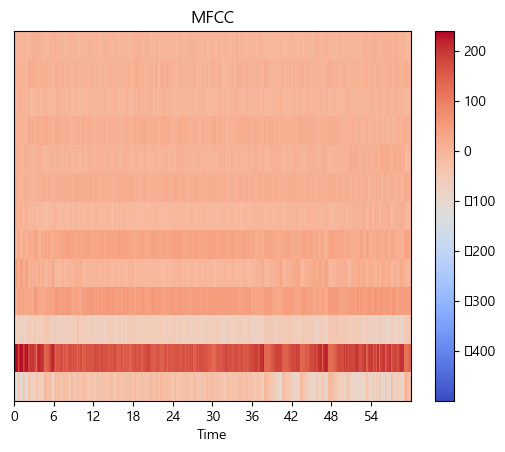

In [3]:
audio_path = r"C:\Users\haim1\fma_medium\001\001017.mp3"

audio, sr = librosa.load(audio_path, sr=None)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc, x_axis='time')
fig.colorbar(img)
ax.set(title='MFCC')

(13, 2498)


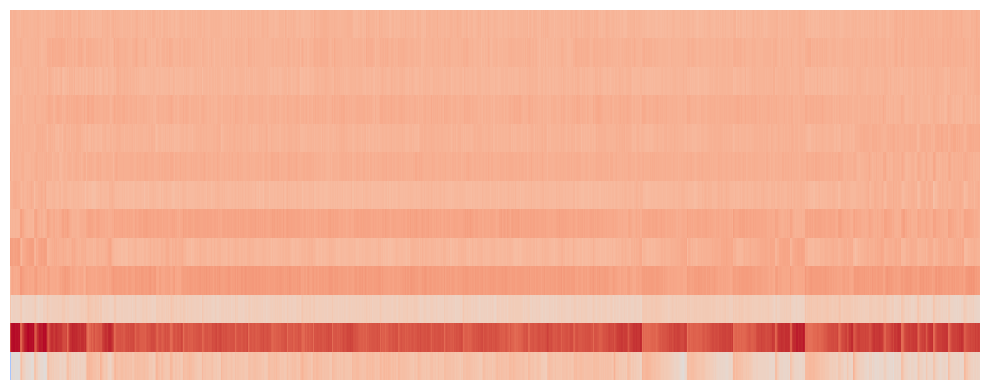

In [29]:
# 현주 (11/20)
# mfcc image test

audio_path = r"C:\Users\haim1\fma_medium\001\001017.mp3"
save_path = r'C:\Users\haim1\mfcc_test_image.jpg'

audio, sr = librosa.load(audio_path, sr=None, duration=29.0)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
print(mfcc.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr)

plt.axis('off')
plt.tight_layout()
# mfcc.jpg 저장
plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
# plt.close()

In [14]:
path = r"E:\UGRP\npy\mfcc\000193\KEY 4 with noise 6_mfcc.npy"
dfjd = np.load(path)
dfjd.shape

(13, 2498)

(12, 2498)


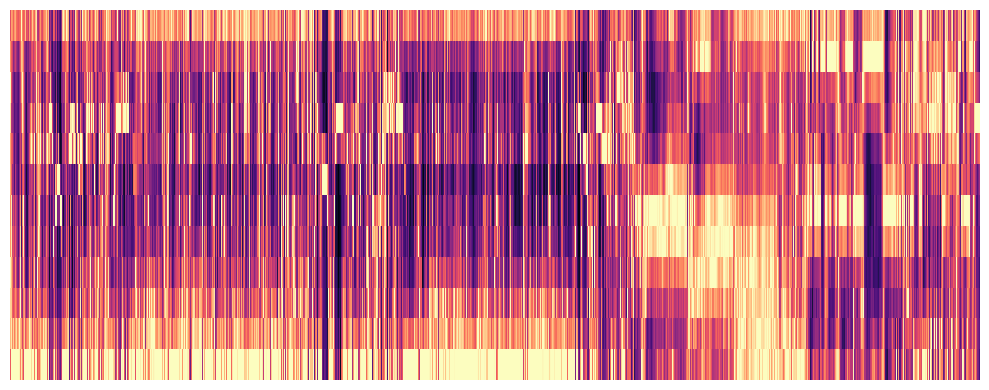

In [30]:
# 현주 (11/22)
# cg image test

audio_path = r"C:\Users\haim1\fma_medium\001\001017.mp3"
save_path = r"C:\Users\haim1\cg_test.jpg"

y, sr = librosa.load(audio_path, sr=None, duration=29.0)
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
print(chromagram.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, sr=sr)
plt.axis('off')
plt.tight_layout()
# chromagram .jpg 저장
plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
# plt.close()

(1025, 2498)


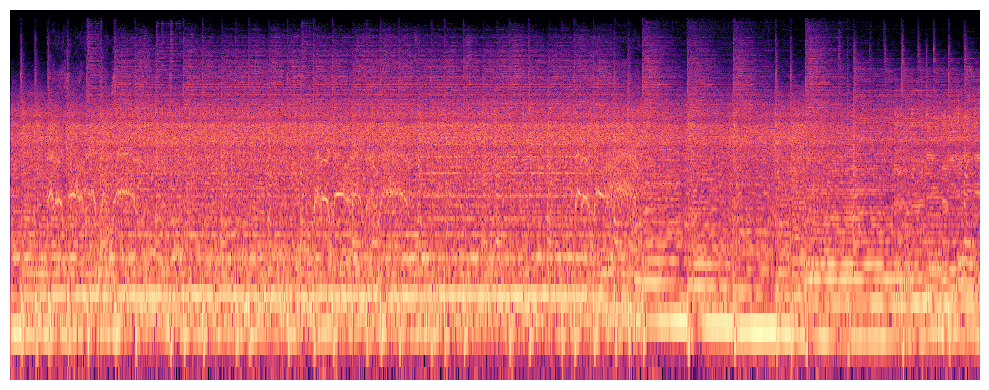

In [41]:
# 현주 (11/22)
# sg image test

audio_path = r"C:\Users\haim1\fma_medium\001\001017.mp3"
save_path = r"C:\Users\haim1\sg_test.jpg"

y, sr = librosa.load(audio_path, sr=None, duration=29.0)
y = librosa.stft(y)
spectrogram = librosa.amplitude_to_db(np.abs(y), ref=np.max)
print(spectrogram.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', sr=sr)
# librosa.display.specshow(spectrogram, sr=sr)
plt.axis('off')
plt.tight_layout()
# sppectrogram .jpg 저장
plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
# plt.close()